# EDS Case Study

Exploring changes in political beliefs

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## Loading and validation


In [2]:
gss = pd.read_hdf('eds.gss.hdf5', 'gss')
gss.shape

(64814, 105)

In [3]:
def replace_invalid(df):

    # recode so depends is in the middle    
    d = {1:1, 2:0, 3:0.5}
    df.trust.replace(d, inplace=True)
    df.helpful.replace(d, inplace=True)
    df.racpres.replace(d, inplace=True)
    df.owngun.replace(d, inplace=True)
    df.fepol.replace(d, inplace=True)
    df.sexeduc.replace(d, inplace=True)

    d = {1:0, 2:1, 3:0.5}
    df.fair.replace(d, inplace=True)

replace_invalid(gss)

In [4]:
vars = ['year', 'id_', 'agewed', 'divorce', 'sibs', 'childs', 'age',
        'educ', 'paeduc', 'maeduc', 'speduc', 'degree', 'padeg', 'madeg',
        'spdeg', 'sex', 'race', 'res16', 'reg16', 'srcbelt', 'partyid',
        'pres04', 'pres08', 'pres12', 'polviews', 'natspac', 'natenvir',
        'natheal', 'natcity', 'natcrime', 'natdrug', 'nateduc', 'natrace',
        'natarms', 'nataid', 'natfare', 'spkath', 'colath', 'libath',
        'spkhomo', 'colhomo', 'libhomo', 'cappun', 'gunlaw', 'grass',
        'relig', 'fund', 'attend', 'reliten', 'postlife', 'pray',
        'relig16', 'fund16', 'sprel16', 'prayer', 'bible', 'racmar',
        'racpres', 'affrmact', 'happy', 'hapmar', 'health', 'life',
        'helpful', 'fair', 'trust', 'conclerg', 'coneduc', 'confed',
        'conpress', 'conjudge', 'conlegis', 'conarmy', 'satjob', 'class_',
        'satfin', 'finrela', 'union_', 'fepol', 'abany', 'chldidel',
        'sexeduc', 'premarsx', 'xmarsex', 'homosex', 'spanking', 'fear',
        'owngun', 'pistol', 'hunt', 'phone', 'memchurh', 'realinc',
        'cohort', 'marcohrt', 'ballot', 'wtssall', 'adults', 'compuse',
        'databank', 'wtssnr', 'spkrac', 'spkcom', 'spkmil', 'spkmslm']

### Validating `polviews`

`polviews` contains responses to the [following question](https://gssdataexplorer.norc.org/projects/52787/variables/178/vshow)

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

The following function takes a variable column and returns a series of values and their frequencies.

In [8]:
def values(series):
    return series.value_counts().sort_index()

In [9]:
values(gss['polviews'])

1.0     1637
2.0     6398
3.0     6865
4.0    21521
5.0     8953
6.0     8149
7.0     1833
Name: polviews, dtype: int64

In [11]:
gss74 = gss['year']==1974
gss74.sum()

1484

In [13]:
values(gss.loc[gss74, 'polviews'])

1.0     21
2.0    191
3.0    201
4.0    543
5.0    252
6.0    169
7.0     34
Name: polviews, dtype: int64

In [14]:
by_year = gss.groupby('year')
by_year

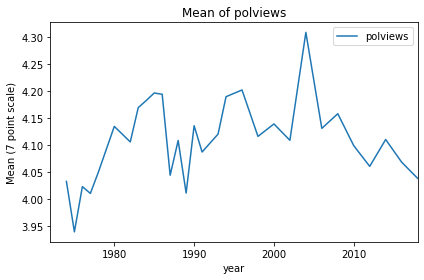

In [20]:
series = by_year['polviews'].mean()
series.plot(label='polviews')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews')

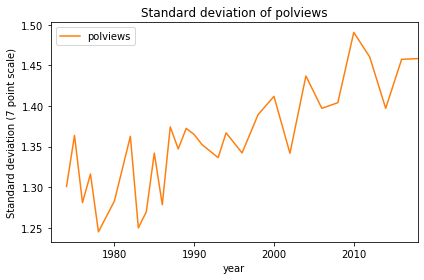

In [30]:
series = by_year['polviews'].std()
series.plot(color='C1', label='polviews')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews')

### Local regression

In [31]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

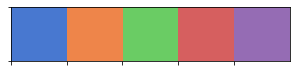

In [32]:
palette = sns.color_palette('muted', 5)
sns.palplot(palette)

In [33]:
colors = dict(Conservative=palette[3], 
              Moderate=palette[4], 
              Liberal=palette[0])

In [47]:
def plot_series_lowess(series, color):
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

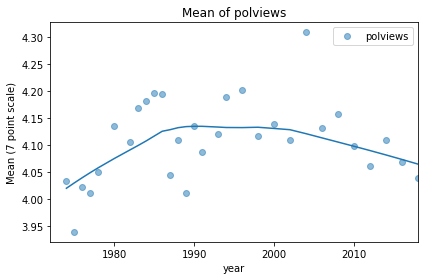

In [35]:
series = by_year['polviews'].mean()
plot_series_lowess(series, 'C0')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of polviews')

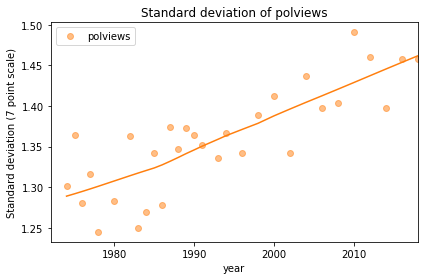

In [36]:
series = by_year['polviews'].std()
plot_series_lowess(series, color='C1')
decorate(ylabel='Standard deviation (7 point scale)',
         title='Standard deviation of polviews')

### 3-point scale

To make it easier to visualize groups, I'm going to lump the 7-point scale into a 3-point scale.

With this scale, there are roughly the same number of people in each group.

In [39]:
# replace 7 point scale with 3 point scale
d = {1:'Liberal', 2:'Liberal', 3:'Liberal', 
     4:'Moderate', 
     5:'Conservative', 6:'Conservative', 7:'Conservative'}
gss['polviews3'] = gss.polviews.replace(d)
values(gss['polviews3'])

Conservative    18935
Liberal         14900
Moderate        21521
Name: polviews3, dtype: int64

In [42]:
def count_by_year(gss, varname):
    """
    """
    grouped = gss.groupby([varname, 'year'])
    count = grouped[varname].count().unstack(level=0)
    
    # note: the following is not ideal, because it does not
    # distinguish 0 from NA
    count = count.replace(0, np.nan).dropna()
    return count

polviews3_count = count_by_year(gss, 'polviews3')
polviews3_count.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,455,413,543
1975,412,424,565
1976,436,389,571
1977,444,426,579
1978,454,396,584


In [43]:
total = polviews3_count.sum(axis=1)
total.head()

year
1974    1411
1975    1401
1976    1396
1977    1449
1978    1434
dtype: int64

In [45]:
polviews3_prop = polviews3_count.div(total, axis=0)
polviews3_prop.head()

polviews3,Conservative,Liberal,Moderate
year,,,
1974,0.322466,0.292700,0.384833
1975,0.294076,0.302641,0.403283
1976,0.312321,0.278653,0.409026
1977,0.306418,0.293996,0.399586
1978,0.316597,0.276151,0.407252


In [48]:
def plot_columns_lowess(df, columns, colors):
    for col in columns:
        series = df[col]
        plot_series_lowess(series, colors[col])

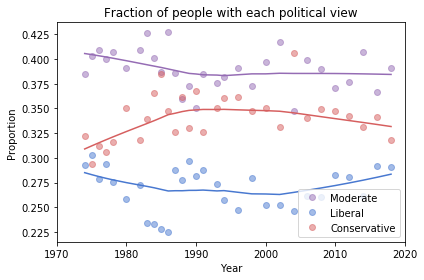

In [49]:
columns = ['Moderate', 'Liberal', 'Conservative']
plot_columns_lowess(polviews3_prop, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each political view',
         xlim=[1970, 2020])

## Trust

In [ ]:
trust_mean = gss.groupby('year').trust.mean().dropna()
trust_mean.head()

In [ ]:
plot_series_lowess(trust_mean, 'C1')
decorate(xlabel='Year',
         ylabel='Fraction',
         title='Can people be trusted',
         xlim=[1970, 2020])

In [ ]:
trust_by_polviews3 = grouped.trust.mean().dropna().unstack(level=0)
trust_by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Conservative', 'Moderate']
plot_columns_lowess(trust_by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Can people be trusted?',
         xlim=[1970, 2020])

## Fair

https://gssdataexplorer.norc.org/projects/52787/variables/440/vshow

Do you think most people would try to take advantage of you if they got a chance, or would they try to be fair?


In [ ]:
fair_mean = gss.groupby('year')['fair'].mean().dropna()
plot_series_lowess(fair_mean, 'C1')
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Would people try to be fair?',
         xlim=[1970, 2020])

In [ ]:
fair_by_polviews3 = grouped['fair'].mean().dropna().unstack(level=0)
fair_by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(fair_by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Would people try to be fair?',
         xlim=[1970, 2020])

## helpful

https://gssdataexplorer.norc.org/projects/52787/variables/439/vshow

Would you say that most of the time people try to be helpful, or that they are mostly just looking out for themselves?


In [ ]:
helpful_mean = gss.groupby('year')['helpful'].mean().dropna()
plot_series_lowess(helpful_mean, 'C1')
decorate(xlabel='Year',
         ylabel='Proportion',
         title='People try to be helpful?',
         xlim=[1970, 2020])

In [ ]:
helpful_by_polviews3 = grouped['helpful'].mean().dropna().unstack(level=0)
helpful_by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(helpful_by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='People try to be helpful?',
         xlim=[1970, 2020])

## homosex

https://gssdataexplorer.norc.org/projects/52787/variables/634/vshow

What about sexual relations between two adults of the same sex--do you think it is always wrong, almost always wrong, wrong only sometimes, or not wrong at all?


In [ ]:
varname = 'homosex'
title='Sexual relations between adults of the same sex'

mean = gss.groupby('year')[varname].mean().dropna()
plot_series_lowess(mean, 'C1')
decorate(xlabel='Year',
         ylabel='Approval',
         title=title,
         xlim=[1970, 2020])

In [ ]:
by_polviews3 = grouped[varname].mean().dropna().unstack(level=0)
by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title=title,
         xlim=[1970, 2020])

## racpres

https://gssdataexplorer.norc.org/projects/52787/variables/400/vshow


If your party nominated a (Negro/Black/African-American) for President, would you vote for him if he were qualified for the job?



In [ ]:
varname = 'racpres'
title='Would you vote for a black person for President'

mean = gss.groupby('year')[varname].mean().dropna()
plot_series_lowess(mean, 'C1')
decorate(xlabel='Year',
         ylabel='Approval',
         title=title,
         xlim=[1970, 2020])

In [ ]:
by_polviews3 = grouped[varname].mean().dropna().unstack(level=0)
by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title=title,
         xlim=[1970, 2020])

## owngun

https://gssdataexplorer.norc.org/projects/52787/variables/679/vshow

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?




In [ ]:
varname = 'owngun'
title='Have gun in home'

mean = gss.groupby('year')[varname].mean().dropna()
plot_series_lowess(mean, 'C1')
decorate(xlabel='Year',
         ylabel='Approval',
         title=title,
         xlim=[1970, 2020])

In [ ]:
by_polviews3 = grouped[varname].mean().dropna().unstack(level=0)
by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title=title,
         xlim=[1970, 2020])

## fepol

https://gssdataexplorer.norc.org/projects/52787/variables/591/vshow

Tell me if you agree or disagree with this statement: Most men are better suited emotionally for politics than are most women.


In [ ]:
varname = 'fepol'
title='Men better suited for politics'

mean = gss.groupby('year')[varname].mean().dropna()
plot_series_lowess(mean, 'C1')
decorate(xlabel='Year',
         ylabel='Approval',
         title=title,
         xlim=[1970, 2020])

In [ ]:
by_polviews3 = grouped[varname].mean().dropna().unstack(level=0)
by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Proportion',
         title=title,
         xlim=[1970, 2020])

## sexeduc

https://gssdataexplorer.norc.org/projects/52787/variables/626/vshow

Would you be for or against sex education in the public schools?




In [ ]:
varname = 'sexeduc'
title='Favor sex education in the public schools?'

mean = gss.groupby('year')[varname].mean().dropna()
plot_series_lowess(mean, 'C1')
decorate(xlabel='Year',
         ylabel='Favor',
         title=title,
         xlim=[1970, 2020])

In [ ]:
by_polviews3 = grouped[varname].mean().dropna().unstack(level=0)
by_polviews3.head()

In [ ]:
columns = ['Liberal', 'Moderate', 'Conservative']
plot_columns_lowess(by_polviews3, columns, colors)
decorate(xlabel='Year',
         ylabel='Favor',
         title=title,
         xlim=[1970, 2020])